# Dask and XGBoost

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" align="left" width="30%" alt="Dask logo">

<img src="https://raw.githubusercontent.com/dmlc/dmlc.github.io/master/img/logo-m/xgboost.png" align="left" width="25%" alt="Dask logo">

XGBoost is a powerful and popular library for gradient boosted trees. For larger datasets or faster training XGBoost also provides a distributed computing solution. Dask-ML can set up distributed XGBoost for you and hand off data from distributed dask.dataframes. This automates much of the hassle of preprocessing and setup while still letting XGBoost do what it does well.

side note: for more on xgboost, read [the story and lessons behind xgboost](https://tqchen.github.io/2016/03/10/story-and-lessons-behind-the-evolution-of-xgboost.html) 

In [1]:
%matplotlib inline
import os
import dask 
import dask.dataframe as dd
import pandas as pd

In [2]:
columnNames = ['UnitPriceMean', 'UnitPriceStd', 'TotalQuantity', 'NoOfUniqueItems', 'NoOfInvoices',
                                'UniqueItemsPerInvoice', 'QuantityPerInvoice', 'SpendingPerInvoice']
customer_normalised = dd.read_csv('../01_super-unsupervised-learning/customer_normalised.csv', usecols=columnNames)

In [3]:
columnName = ['customer_value']
customer_value_label = dd.read_csv('../01_super-unsupervised-learning/customer_value_label.csv', header=None, names=columnName)

In [4]:
customer_normalised.head()

,UnitPriceMean,UnitPriceStd,TotalQuantity,NoOfUniqueItems,NoOfInvoices,UniqueItemsPerInvoice,QuantityPerInvoice,SpendingPerInvoice
0,4.134921,2.559095,505.0,44.0,5.0,12.600000,101.000000,250.536000
1,3.281867,4.673614,1719.0,50.0,4.0,18.750000,429.750000,655.107500
2,6.790784,6.478746,472.0,41.0,7.0,7.285714,67.428571,282.884286
3,1.899752,1.836582,1491.0,86.0,7.0,17.000000,213.000000,266.394286
4,4.044118,2.288687,442.0,15.0,4.0,4.250000,110.500000,465.425000


In [5]:
customer_normalised.dtypes

UnitPriceMean            float64
UnitPriceStd             float64
TotalQuantity            float64
NoOfUniqueItems          float64
NoOfInvoices             float64
UniqueItemsPerInvoice    float64
QuantityPerInvoice       float64
SpendingPerInvoice       float64
dtype: object

In [6]:
customer_value_label.head()

,customer_value
0,high
1,high
3,low
4,high
5,high


In [7]:
# convert labels to boolean format
is_valuable_customer = (customer_value_label == 'high')
is_valuable_customer.head()

,customer_value
0,True
1,True
3,False
4,True
5,True


In [8]:
is_valuable_customer.dtypes

customer_value    bool
dtype: object

The `dask-xgboost` library provides a small wrapper around `dask-xgboost` for passing dask objects to `xgboost`.

# Train-test split

In [9]:
customer_normalised_train, customer_normalised_test = customer_normalised.random_split([0.8, 0.2], random_state=1234)
is_valuable_customer_train, is_valuable_customer_test = is_valuable_customer.random_split([0.8, 0.2], random_state=1234)

In [10]:
from dask.distributed import Client
client = Client()
client # start a local Dask client

Client Scheduler: tcp://127.0.0.1:51554 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [11]:
%%time
from dask_searchcv import GridSearchCV
from dask_ml.xgboost import XGBClassifier

bst = XGBClassifier()

bst.fit(customer_normalised_train, is_valuable_customer_train)

CPU times: user 384 ms, sys: 131 ms, total: 516 ms
Wall time: 1.28 s


In [12]:
import matplotlib.pyplot as plt
import xgboost as xgb

/Users/jeanne/anaconda3/envs/dask-tutorial/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


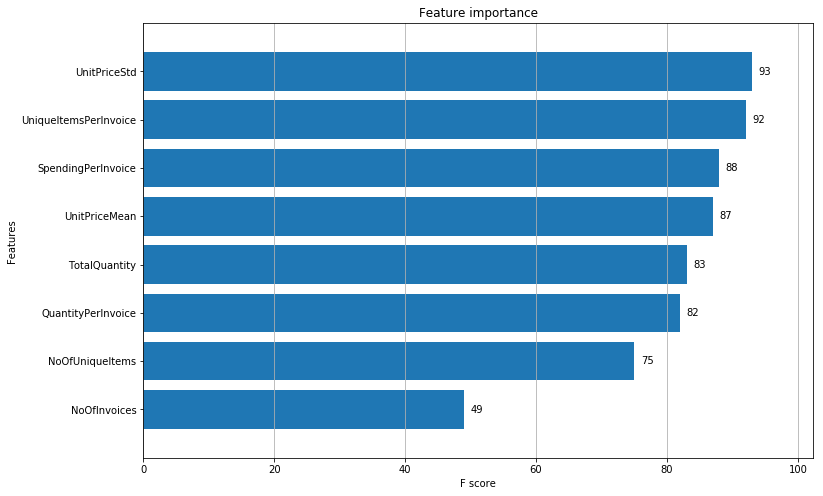

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20)
ax.grid("off", axis="y")

In [14]:
bst.score(customer_normalised_train, is_valuable_customer_train)

0.5107480653482374

In [15]:
bst.score(customer_normalised_test, is_valuable_customer_test)

0.49473684210526314

In [16]:
predictions = bst.predict(customer_normalised_test)
predictions = client.persist(predictions)
predictions

Dask Series Structure:
npartitions=1
    int64
      ...
Name: predictions, dtype: int64
Dask Name: astype, 1 tasks

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

In [18]:
print(roc_auc_score(is_valuable_customer_test.compute(),
                             predictions.compute()))

0.5


# Iris data Grid Search Example 

In [38]:
import dask_searchcv as dcv
# from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
iris = datasets.load_iris()
parameters = {'kernel': ['linear', 'rbf'], 'C': [1, 10]}
svc = svm.SVC()
clf = dcv.GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)  

GridSearchCV(cache_cv=True, cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': [1, 10]}, refit=True,
       return_train_score='warn', scheduler=None, scoring=None)

grid search with ecommerce data was buggy but can be tried as an exercise for the learner

# Extension 

Example implementing Dask xgboost on a distributed cluster

In [12]:
import os
from dask import compute, persist
from dask.distributed import Client, progress

client = Client(os.environ.get("DISTRIBUTED_ADDRESS"))  # connect to cluster 

We'll work through an example using the airlines dataset.
For a recorded screen cast, see [here](https://www.youtube.com/watch?v=Cc4E-PdDSro).
Our task is to pick whether or not a flight was delayed for more than 15 minutes.

First, let's load the data.

In [13]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance',
        'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
df = dd.read_csv('s3://dask-data/airline-data/2006.csv', usecols=cols,
                 storage_options={'anon': True})

frac = 0.01
df = df.sample(frac=frac) # we blow out ram otherwise

is_delayed = (df.DepDelay.fillna(16) > 15)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
df.head()

In [ ]:
is_delayed.head()

In [ ]:
df2 = dd.get_dummies(df.categorize()).persist()

## Split and Train

We'll split the original dataset into train and test sets.
The model will be fit on `data_train` and evaluated on `data_test`.

In [ ]:
data_train, data_test = df2.random_split([0.9, 0.1], 
                                         random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.9, 0.1], 
                                                    random_state=1234)

Now we can fit the model. This is exactly like normal, except you'll import `dask_xgboost`.
It will take care of handing the data off to the distributed `xgboost` processes, and from there everything proceeds as normal.

In [ ]:
%%time
import dask_xgboost as dxgb
import xgboost as xgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1}

bst = dxgb.train(client, params, data_train, labels_train)
bst

The `bst` object is just a reguler `xgboost.Booster`, so all the familar methods are available.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20)
ax.grid("off", axis="y")

Let's get the predictions. The is the same as usual, except we're using `dxgb`.

In [ ]:
predictions = dxgb.predict(client, bst, data_test)
predictions = client.persist(predictions)
predictions

The `predictions` object is a `dask.Series`, so it can be used in place of a numpy array in most places.

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(labels_test, predictions)
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (ares = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)

ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();